# **Instituto Tecnológico y de Estudios Superiores de Monterrey**

## **Escuela de Ingeniería y Ciencias**

## **Maestría en Inteligencia Artificial Aplicada**

### **Dra. Grettel Barceló Alonso**

### **Dr. Luis Eduardo Falcón Morales**

**Materia Proyecto integrador**

**Avance 2. Ingeniería de características**

**Equipo 11**

**José Gilberto Amaro Aceves - A01794815**

**Francisco Antonio Enríquez Cabrera - A01795006**

**Carlos Eduardo García García - A01795206**  

Fecha: 18-05-2025



---



# Esquema General

1. Configuración inicial: se importan las librerías a implementar.
2. Se hace una configuración global de las variables.
3. Se hace una defición de las funciones que servirán de apoyo
4. Se hace el modelado por país.
5. Modelado de consolidado total
6. Orquestador Principal
7. Se hace un efoque evaluativo con la ejecución de curvas de aprendizaje
8. Características importantes
9. Resultados y Conclusiones



---



# 1. Configuración inicial: declaración de las librerías a implementar.
**Descripción:**
  
  1.1 Se importan las librerías para la configuración del pipeline así como las librerías de anñalisis de datos y visualización.
  
  1.2 Se realiza la configuración del respositorio de los gráficos y tablas.
  
  1.3 Se importa la librería joblib, para establecer el límite de serialiazación, en caso de usar random Forests.
  
  1.4 Se silencian los warnings para las funciones learning_curve y ConvergeWarning.


**Justificación:**

La intención de este bloque es establecer el entorno los suficientemente robusto para procesar series de tiempo, la evaluación del modelo, evitar interrupciones de warnings y establecer el destino de los resultados obtenidos.

In [ ]:
"""
Módulo principal del *pipeline* de modelado para el proyecto de
exportaciones / producción de tequila.

Funciones clave
1.  Carga los datasets *_features.csv* generados en la fase previa de
    ingeniería de características.
2.  Ajusta **RandomForestRegressor** con validación temporal
    (`TimeSeriesSplit`) y búsqueda de hiperparámetros reducida
    (`GridSearchCV`).
3.  Genera proyecciones a 2040 y *back-casts* (2010-2015-2020) para
    control de calidad.
4.  Calcula métricas (MAE, RMSE, R², …) y las guarda en CSV.
5.  Serializa los *pipelines* (`joblib`) y crea visualizaciones
    (curvas de aprendizaje e importancias de variables) en PNG.
6.  Está diseñado para ejecutarse **tanto local (Windows/Linux) como en
    Google Colab** – sólo hay que modificar las rutas `BASE_PATH`
    y `RESULT_PATH` en la sección CONFIG.
"""

from __future__ import annotations

# ≡━━━━━━━━━━━━━━━━━━  IMPORTS ESTÁNDAR  ━━━━━━━━━━━━━━━━━━≡
import json
import os
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# ≡━━━━━━━━━━━━━━  NUMPY / PANDAS / PLOTTING  ━━━━━━━━━━━━━≡
import numpy as np
import pandas as pd
import matplotlib

# ── backend 'Agg' → renderiza figuras en disco (no en pantalla) ──
matplotlib.use("Agg")
import matplotlib.pyplot as plt   # noqa: E402  (import después del backend)

# ≡━━━━━━━━━━━━━━━  SERIALIZACIÓN (JOBLIB)  ━━━━━━━━━━━━━━━≡
import joblib

# El límite por defecto (≈100 MB) es muy bajo para Random Forests grandes
joblib.DEFAULT_MAX_BYTES = 1_000_000_000  # 1 GB

# ≡━━━━━━━━━━━━━━  SCIKIT-LEARN CORE IMPORTS  ━━━━━━━━━━━━━≡
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
    mean_absolute_percentage_error,
    explained_variance_score,
    max_error,
)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

# ≡━━━━━━━━━━━━━━  GESTIÓN DE *WARNINGS*  ━━━━━━━━━━━━━━━━≡
import warnings
from sklearn.exceptions import ConvergenceWarning

# Silencia *RuntimeWarning* inofensivo generado por `learning_curve`
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="Removed duplicate entries from 'train_sizes'",
)
# Opcional: silenciar algunos *ConvergenceWarning* de sklearn
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 2. Configuración global de las variables.

**Descripción:**
  
  1.1 Se define el umbral para el error respecto a la métrica MAE ( Mean Aboslute Error): UMBRA_MAE.
  
  1.2 Se establecen los porcentajes para particionar el dataset: 66% entrenamiento y 34% validación.
  
  1.3. Se configura la aleatoriedad en la elección de los datos de entrenamiento y validación.
  
  1.4 Se monta el drive en el Colab
  
  1.5 Se definen las rutas para la extracción de la data, resultados y el modelo.
  
  1.6 Se crean las carpetas, en caso de no existir, en donde se depositarán los archivos resultados de la ejecución.

  1.7 Configuración del parámetro para evaluer el modelos en el pasado 2010, 2015 y 2020.

**Justificación:**

  La inclusión de este bloque se debe a que los parámetros del entorno del modelado sean transparentes para establecer una trazabilidad en los experimentos. Organiza las rutas y métricas para tener mayor limpieza y reproducibilidad si se agregan otros modelos.

  Hacer una validación en retrospectiva es un mecanismo de validación robusta.

In [ ]:
# ═════════════════════ CONFIGURACIÓN GLOBAL ═════════════════════
# ── umbral objetivo de MAE (litros) para aceptar un modelo
UMBRAL_MAE: float = 10_000

# ── Nº de divisiones en TimeSeriesSplit (3 = train 66 %, val 33 %)
N_SPLITS: int = 3

# ── semilla reproducible para sklearn / numpy
RANDOM_STATE: int = 42

# ── Montaje de Google Drive (sólo Colab) y rutas base
from pathlib import Path
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

# Dataset de entrada (“data”) y carpetas de salida (resultados + modelos)
BASE_PATH   = Path("/content/drive/MyDrive/ProyectoIntegrador/ModeloPronosticos/data")
RESULT_PATH = BASE_PATH.parent / "resultados"
MODEL_PATH  = RESULT_PATH / "models"

RESULT_PATH.mkdir(parents=True, exist_ok=True)
MODEL_PATH.mkdir(exist_ok=True)

# ── años para *back-casting* (control de calidad)
BACKCAST_YEARS = [2020, 2015, 2010]

Mounted at /content/drive


# 3. Defición de las funciones que servirán de apoyo.

**Descripción:**

3.1.1 Elección de las métricas y evaluación. Se define el RMSE para reportar el error con las mismas unidades que la variable objetivo.

3.1.1 Se guardan los resultados de las métricas en un archivo de tipo csv.


3.2.1 Detección de los outliers con la función detectar_outliers_iqr, usando el rango intercuartílico para identificar los valores atípicos de las series numéricas.

3.3.1 Se reconstruyen los valores históricos mediante la función backast_years. El objetivo es para los datos reales use la mediana y la media para dummies. En ausencia de datos se crea el vector cero. Finalmente se la predicción vs el valor real medianre el error porcentual obsoluto.

3.4.1 Se realice un filtrado de las variables con poco peso [low_importance_out_flags(...)], relativos al umbral cuyo valor por defecto es  (0.2%). Una vez identificacas las columnas, que están debajo del umbral, son eliminadas del dataframe [drop_low_importance_flags(...)].

3.5.1 Mediante la función [ensure_categoria_clase(...)], se reconstruyen las variables "Categoría" o "Calse".


**Justificación:**

Este conjunto de funciones son nuestras herramientas auxiliares para agregar robustez al modelo, ejecutando una valuación respecto al pasado; con ello queremos asegurar la reducción del overfitting al eliminar las variables irrelevantes.

In [ ]:
# ═════════════════════ UTILIDADES GENERALES ═════════════════════
def root_mean_squared_error(y_true, y_pred) -> float:
    """RMSE rápido para imprimir / loggear."""
    return np.sqrt(mean_squared_error(y_true, y_pred))


def detectar_outliers_iqr(y: pd.Series) -> pd.Series:
    """
    Regresa una **máscara booleana** con outliers según la regla IQR × 1.5.
    Uso:  df = df[~detectar_outliers_iqr(df["columna"])]
    """
    q1, q3 = np.percentile(y, [25, 75])
    iqr    = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return (y < low) | (y > high)


def guardar_metricas_csv(metricas: dict, archivo: Path) -> None:
    """
    Añade un renglón al CSV *archivo* (creándolo si no existe).
    metricas : diccionario plano {columna: valor}
    """
    pd.DataFrame([metricas]).to_csv(
        archivo, mode="a", header=not archivo.exists(), index=False
    )
# ════════════════════════════════════════════════════════════════


# ═════════════ BACK-CAST: PREDICCIONES HISTÓRICAS ═══════════════
def backcast_years(
    pipe: Pipeline,
    X_cols: List[str],
    df_hist: pd.DataFrame,
    target: str,
    years: List[int],
    *,
    year_col: str = "Year",
) -> pd.DataFrame:
    """
    Genera predicciones “hacia atrás” (back-cast) para *years* y compara con
    el valor real disponible en `df_hist`.

    Estrategia para construir la fila de entrada:
    ▸ Si hay registros reales en ese año:
        • Variables numéricas  → mediana.
        • Dummies / categóricas→ moda (0/1 más frecuente).
    ▸ Si NO hay registros reales:
        • Crea un vector “cero” (salvo la columna Year).
    Devuelve un DataFrame:  Year | Pred | Real | AbsPct(%) .
    """
    rows: list[dict] = []

    for yr in years:
        df_yr = df_hist.loc[df_hist[year_col] == yr]

        # ➊ Construir X_row ───────────────────────────────────────────
        if df_yr.empty:
            # Año sin datos → vector nulo
            x_row = pd.DataFrame({c: 0 for c in X_cols}, index=[0])
        else:
            # Mediana de numéricas
            num_med = df_yr[X_cols].select_dtypes("number").median()
            # Moda de dummies / categóricas
            mode = df_yr[X_cols].mode().iloc[0]
            x_row = pd.DataFrame([{**mode, **num_med}], columns=X_cols).fillna(0)

        if year_col in X_cols:
            x_row[year_col] = yr

        # ➋ Predicción y comparación ────────────────────────────────
        pred = float(pipe.predict(x_row)[0])
        real_vals = df_yr[target]
        real = float(real_vals.mean()) if not real_vals.empty else np.nan
        abs_pct = abs(pred - real) / real * 100 if not np.isnan(real) else np.nan

        rows.append(dict(Year=yr, Pred=pred, Real=real, AbsPct=abs_pct))

    return pd.DataFrame(rows)
# ════════════════════════════════════════════════════════════════


# ═══════════  IMPORTANCIA DE BANDERAS “FlagOut_*”  ═══════════════
def low_importance_out_flags(
    pipe: Pipeline,
    X: pd.DataFrame,
    threshold: float = 0.002,
) -> Tuple[List[str], pd.Series]:
    """
    Identifica columnas que empiezan por **'FlagOut_'** y cuyo peso en el RF
    es < *threshold* (0.2 %).

    Retorna
    -------
    low_flags : list[str]
        Columnas prescindibles.
    out_imp   : pd.Series
        Importancia completa (ordenada ‘desc’).
    """
    rf = pipe["rf"]
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    mask = importances.index.str.startswith("FlagOut_")
    out_imp = importances[mask].sort_values(ascending=False)
    low_flags = out_imp[out_imp < threshold].index.tolist()
    return low_flags, out_imp


def drop_low_importance_flags(df: pd.DataFrame, low_flags: List[str]) -> pd.DataFrame:
    """Elimina del DataFrame las columnas listadas en *low_flags*."""
    return df.drop(columns=[c for c in low_flags if c in df.columns], errors="ignore")
# ════════════════════════════════════════════════════════════════


# ═══════ RECONSTRUIR 'Categoria' / 'Clase' A PARTIR DE DUMMIES ══
def ensure_categoria_clase(df: pd.DataFrame) -> pd.DataFrame:
    """
    Garantiza que existan columnas **Categoria** y **Clase** con texto.

    Si sólo hay dummies (Categoria_*, Clase_*), toma la columna de
    mayor valor (=1) y extrae el sufijo.
    """
    if "Categoria" not in df.columns:
        cat_dummies = [c for c in df.columns if c.startswith("Categoria_")]
        if cat_dummies:
            df["Categoria"] = (
                df[cat_dummies].idxmax(axis=1).str.replace("Categoria_", "")
            )

    if "Clase" not in df.columns:
        cls_dummies = [c for c in df.columns if c.startswith("Clase_")]
        if cls_dummies:
            df["Clase"] = df[cls_dummies].idxmax(axis=1).str.replace("Clase_", "")

    return df

# 4.1 Construcción y Evaluación del Modelo

**Descripción:**

4.1.1.1 Se construye el pipeline base para el modelo de random Forest con la definición [make_rf_pipeline(...)]. Este pipeline consiste de las dos etapas siguientes:


1.   Selección de las características usando "SelectkBest", aquí se aplica la selección univariada con el método de regresión "f_regression".
2.   Entrenamiento del Modelo Random Forest: los parámetros elegidos son:


* n_estimators=200: número de árboles del ensamble.

* max_depth: permite limitar la profundidad de los árboles.

* min_samples_leaf=3: evita ramas con pocos datos (regularización).

* n_jobs=-1: usa todos los núcleos de CPU.

* random_state: garantiza reproducibilidad.

4.1.1.2 Finalmente se devuelve el pipeline listo para usarse en validación cruzada o bien afinar hiperparámetros.

**Justificación:**

El modularizar los pipeline para cada modelo nos da mayor claridad y reproducibilidad al cambiar de modelo.

Podrán evitarse configuraciones manuales en la evaluaciones y ajustes de hiperparámetros.

Creemos que se puede combinar un conjunto de variables que atienden a un modelo nolineal con datos con ruido y valores atípicos importantes.

Los pipeline nos permiten compactar el preprocesamiento y modelado como un solo objeto. Nuestro propósito es usar las métricas/métodos de cross validation o GridSearchCV.

Para este primer modelo baseline, se eligió el Random Forest Regressor por su capacidad de ser robusto frente a outliers, además de que sabemos que tenemos presencia de relaciones no lineales de acuerdo a nuestro análsisi EDA.

**Justificación métrica escogida**

 Se escogió **MAE** como la métrica a seguir debido a que esta métrica castiga menos los errores grandes basados por outliers que es un caso comun en este escenario debido a los factores externos que pueden influenciar la cantidad de exportaciones.


In [ ]:
# ════════════════ CONSTRUCCIÓN Y EVALUACIÓN DEL MODELO ═══════════════════

# ───────────────────── Pipeline base de RandomForest ─────────────────
def make_rf_pipeline(
    n_estimators: int = 200,
    max_depth: Optional[int] = None,
    min_samples_leaf: int = 3,
) -> Pipeline:
    """
    Genera un **Pipeline** que aplica:
    1. `SelectKBest`  – filtro univariado (f-regression).
       k="all": no descarta, pero deja el paso preparado para GridSearch
       future (p.ej. k="auto" en sklearn ≥1.5).
    2. `RandomForestRegressor` – modelo robusto a outliers y escalas.

    Parámetros
    ----------
    n_estimators      : nº árboles; 200 es buen balance velocidad / varianza.
    max_depth         : None → sin tope; valores bajos se prueban en grid.
    min_samples_leaf  : regulariza nodos muy pequeños.
    """
    return Pipeline(
        steps=[
            ("selector",
             SelectKBest(score_func=f_regression, k="all")),
            ("rf",
             RandomForestRegressor(
                 n_estimators=n_estimators,
                 max_depth=max_depth,
                 min_samples_leaf=min_samples_leaf,
                 n_jobs=-1,               # usa todos los cores disponibles
                 random_state=RANDOM_STATE,
             )
            ),
        ]
    )

# 4.2 Evaluación, ajuste y serialización del modelo Random Forest

4.2.1.1 Se calcula el MAE promedia con la función "TimeSeriesSplit".

4.2.1.2 Optimización de hiperparámetros. Se configura la profundidad de los datos (max_depth), el número de árboles (n_estimators) y el tamaño mínimo de hojas (min_samples_leaf).

4.2.1.2 Se usa la malla PARAM_GRID_RF, devolviendo el mejor pipeline con su respectivo MAE.

4.2.1.3 Para la serialización se gurada el modelo en los archivos .pkl y en
un archivo json, se guardan los metadatos del experimento como el modelo, la fecha, los hiperparámetros, el MAE y la versión.

4.2.1.4 Se genera una proyección futura para el año 2040, usando un vecotr cero; con ello pordremos seguir implementando el modelo para datos futuros, aùn sin haber datos futuros reales.

**Justificación**

Los modelos tienen un ciclo de vida, con este apartado, documentamos toda la acción del modelo guardando la evaluación del rendimiento, optmizando el modelo con hiperparámetros, y habilitando proyecciones futuras.

In [ ]:
# ───────────────────── Validación con TimeSeriesSplit ────────────────
def cv_mae_score(
    pipe: Pipeline,
    X: pd.DataFrame,
    y: pd.Series,
) -> float:
    """
    Calcula el **MAE medio** usando `TimeSeriesSplit`.

    Devuelve el error como valor *positivo* (se multiplica por –1 internamente
    porque sklearn reporta “neg_mean_absolute_error”).
    """
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    mae_neg = cross_val_score(
        pipe, X, y,
        cv=tscv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
    )
    return -mae_neg.mean()

# ───────────────────── GridSearch reducido de hiper-params ───────────
PARAM_GRID_RF = {
    # mantener la malla pequeña acelera ~×5 sin bajar performance
    "rf__n_estimators":     [200],
    "rf__max_depth":       [None, 10],
    "rf__min_samples_leaf": [3],
}

def gridsearch_rf(
    X: pd.DataFrame,
    y: pd.Series,
    base_pipe: Pipeline | None = None,
) -> Tuple[Pipeline, float]:
    """
    Ejecuta **GridSearchCV** con validación temporal y devuelve:
    • `best_estimator_`  (Pipeline óptimo)
    • `best_mae`         (MAE CV positivo)

    El espacio de búsqueda se define en `PARAM_GRID_RF`.
    """
    pipe = base_pipe or make_rf_pipeline()
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    gs = GridSearchCV(
        pipe,
        PARAM_GRID_RF,
        cv=tscv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        verbose=0,
            error_score='raise'

    )
    gs.fit(X, y)
    best_mae = -gs.best_score_
    return gs.best_estimator_, best_mae

# ───────────────────── Serialización & metadatos ─────────────────────
def save_pipeline(
    pipe: Pipeline,
    nombre: str,
    mae_cv: float,
    dataset: str,
) -> None:
    """
    Guarda:
    • `models/<nombre>.pkl`   –  Pipeline entrenado (joblib).
    • `models/<nombre>.json` –  metadatos reproducibles:
        - dataset de origen
        - arquitectura del modelo
        - MAE CV
        - timestamp y versión sklearn
        - hiper-parámetros completos
    """
    pkl_file  = MODEL_PATH / f"{nombre}.pkl"
    meta_file = MODEL_PATH / f"{nombre}.json"

    joblib.dump(pipe, pkl_file)

    meta = {
        "dataset": dataset,
        "modelo": "RandomForest + SelectKBest",
        "mae_cv": mae_cv,
        "fecha_entrenamiento": datetime.now().isoformat(timespec="seconds"),
        "sklearn_version": joblib.__version__,
        "n_splits": N_SPLITS,
        "parametros": pipe.get_params(),
    }
    meta_file.write_text(json.dumps(meta, indent=2, default=str))

# ───────────────────── Proyección a un año futuro ────────────────────
def proyectar_anyo(
    pipe: Pipeline,
    X_cols: List[str],
    *,
    future_year: int = 2040,
    year_col: str = "Year",
) -> float:
    """
    Genera una FILA “vacía” (todas las features = 0 salvo `Year`)
    y devuelve la predicción del Pipeline.

    Usado para proyecciones a 2040, pero admite cualquier año.
    """
    X_future = pd.DataFrame({c: 0 for c in X_cols}, index=[0])
    X_future[year_col] = future_year
    return float(pipe.predict(X_future)[0])

# 4.3 Definición de la función para la ejecución del modelo por país.

**Descripción:*

4.3.1 Filtrado & limpieza del histórico (`<=2022`, sin outliers IQR).

4.3.2 Elección de las variables feature y target **X / y** conservando solo variables numéricas.

4.3.3 Selección del Dummy-baseline (``DummyRegressor``) → MAE de referencia.

4.3.4 Calculo el modelo base midiendo el MAE promedio; este es un modelo dummy.

4.3.5 Entrena un modelo RandomForest usando GRidSearchCV, para optimizar los hiperparámetros con validación temporal (TimeSeriesSplit). Finalmente, se ajusta el modelo final con todos los datos posibles.

    1.   Se descarta `FlagOut_*` poco relevantes
         (<0.2 % de importancia).
    2.   Guarda:
         * Curva de aprendizaje (PNG)
         * Top-20 importancias (PNG)
         * Pipeline + metadatos (`save_pipeline`)
    3.   Back-casting a años “pasados” (`BACKCAST_YEARS`) para auditar exactitud.

4.3.6 Hace la proyección para el año 2040 estimando el volumen exportado usando el modelo entrenado.

4.3.7 Hace la comparativa del modelo con backcasting usando una reconstrucción para los años 2010, 2015 y 2020. Se guarda el resultado en la tabla backcast_<pais>.csv.


**Justificación**

En este pipeline se integran los modelos por país asegurando un preprocesamiento confiable y una comparación en el baseline. Se automatiza la optimización del modelos además de aplicar una validación de tipo retrospectivo.




In [ ]:
# ───────────────────── Modelado por país (Total_Pais_Mes) ─────────────
def run_pais_total(
    df_paises: pd.DataFrame,
    pais: str,
) -> Optional[float]:
    """
    Entrena un `RandomForest` (vía ``gridsearch_rf``) para el país indicado y
    devuelve la proyección de litros exportados **en 2040**.

    Etapas
    ------
    1.   Filtrado & limpieza del histórico (`<=2022`, sin outliers IQR).
    2.   Split **X / y** conservando solo variables numéricas.
    3.   Dummy-baseline (``DummyRegressor``) → MAE de referencia.
    4.   GridSearchCV con TimeSeriesSplit:
         * refina hiper-parámetros en `PARAM_GRID_RF`.
    5.   *Embedded feature selection*: descarta `FlagOut_*` poco relevantes
         (<0.2 % de importancia).
    6.   Guarda:
         * Curva de aprendizaje (PNG)
         * Top-20 importancias (PNG)
         * Pipeline + metadatos (`save_pipeline`)
    7.   Back-casting a años “pasados” (`BACKCAST_YEARS`) para auditar exactitud.

    Parameters
    ----------
    df_paises : DataFrame
        Dataset completo con *features* y objetivos.
    pais : str
        Nombre (uppercase) del país a modelar.

    Returns
    -------
    float | None
        Litros estimados para 2040, o `None` si no hay datos suficientes.
    """
    # --- Selección y pre-procesamiento -----------------------------------
    df_p = df_paises[df_paises["NombrePais"] == pais].copy()
    if df_p.empty:
        print(f"[warn] No hay registros para '{pais}'.")
        return None

    df_p = asegurar_columna_year(df_p)
    df_p = df_p[df_p["Year"] <= 2022].drop_duplicates(subset=["Year"])
    df_p = df_p[~detectar_outliers_iqr(df_p["Total_Pais_Mes"])]

    # --- División X / y ---------------------------------------------------
    X, y = split_Xy(
        df_p,
        target="Total_Pais_Mes",
        drop_cols=["Year_Binned"] if "Year_Binned" in df_p else None,
    )
    X = X.assign(Year=df_p["Year"].values)

    # --- Baseline naïf ----------------------------------------------------
    dummy_mae = -cross_val_score(
        DummyRegressor(strategy="mean"),
        X, y,
        cv=TimeSeriesSplit(n_splits=N_SPLITS),
        scoring="neg_mean_absolute_error"
    ).mean()

    # --- Grid-search RF ---------------------------------------------------
    best_pipe, mae_cv = gridsearch_rf(X, y)
    best_pipe.fit(X, y)

    # --- Limpieza de FlagOut_* irrelevantes -------------------------------
    low_flags, _ = low_importance_out_flags(best_pipe, X, threshold=0.002)
    if low_flags:
        X2 = drop_low_importance_flags(X, low_flags)
        if X2.shape[1] < X.shape[1]:                # se descartó algo
            pipe2, mae_cv2 = gridsearch_rf(X2, y)
            pipe2.fit(X2, y)
            if mae_cv2 <= mae_cv + 1:               # mejora (±1 L toler.)
                best_pipe, mae_cv, X = pipe2, mae_cv2, X2

    # --- Visual: importancias --------------------------------------------
    importances = pd.Series(best_pipe["rf"].feature_importances_, index=X.columns)
    (importances.nlargest(20)
                .plot.barh(figsize=(5, 6), title=f"Importancia – {pais} (top 20)"))
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(RESULT_PATH / f"imp_{pais}.png", dpi=150)
    plt.close()

    # --- Serializar modelo -----------------------------------------------
    model_id = f"pais_total_{pais.lower().replace(' ', '_')}"
    save_pipeline(best_pipe, model_id, mae_cv, dataset="paises")

    # --- Proyección 2040 --------------------------------------------------
    pred_2040 = proyectar_anyo(best_pipe, X.columns.tolist(), future_year=2040)
    print(f"\n {pais:25s} | MAE CV: {mae_cv:,.1f} | Pred 2040: {pred_2040:,.0f} L  "
          f"(Dummy MAE: {dummy_mae:,.1f})")

    # --- Check umbral -----------------------------------------------------
    print("Modelo mayor o igual al desempeno minimo" if mae_cv <= UMBRAL_MAE else "Modelo mayor o igual al desempeno minimo")

    # --- Curva de aprendizaje --------------------------------------------
    plot_learning_curve(best_pipe, X, y, pais, RESULT_PATH / f"lc_{pais}.png")

    # --- Back-cast --------------------------------------------------------
    back_df = backcast_years(best_pipe, X.columns.tolist(), df_p,
                             "Total_Pais_Mes", BACKCAST_YEARS)
    print("Back-cast:")
    print(back_df.to_string(index=False,
                            formatters={
                                "Pred": "{:,.0f}".format,
                                "Real": "{:,.0f}".format,
                                "AbsPct": lambda x: f"{x:.1f}%"
                                    if not np.isnan(x) else "N/A"}))
    back_df.to_csv(RESULT_PATH / f"backcast_{pais}.csv", index=False)

    # --- Log métrica global ----------------------------------------------
    guardar_metricas_csv(
        {"Dataset": "paises", "Pais": pais,
         "MAE_CV": mae_cv, "Pred_2040": pred_2040},
        RESULT_PATH / "metricas_paises.csv",
    )

    return pred_2040

# 4.4 Definición de la función por categoría y clase.

**Descripción:**

4.4.1 Se filtran los datos del país elegido, verificando que incluya el cálculo del total para 2040.

4.4.2 Se realiza un preprocesamiento agregando la columan "Year" y reconstruyendo las columnas de "Categoría" y Clase. Finalmente, se hace el cálculo de Porcentaje = Total_Categoria_Mes / Total_Pais_Mes.

4.4.3 Se realiza el modelado agrupando los datos por categoría y clase. Se entrena el modelo con RandomForest, se hace la predicción de la participación porcentual y la convierte a litros (pct × total_2040).

4.4.4 Se realiza la normalización de los porcentajes asegurando que la suma total de participaciones sea igua a 1.

4.4.5 Se realiza el reporte guardando los datos predicho en un archivo CSV con:

Categoria, Clase

Porcentaje_Normalizado

Litros_Estimados

**Justificación:**


Con esta función se permite hacer una despomposición de la proyección total en términos de la categoría (Tequila, Tequila 100%) y clase (Añejo, Blanco, Reposado).


In [ ]:
# ─────────────────── Distribución % categoría–clase 2040 ──────────────
def run_porcentaje_categoria_clase(
    df_paises: pd.DataFrame,
    pais: str,
    total_2040: float,
) -> None:
    """
    Estima la composición porcentual (Categoría, Clase) del volumen total
    **proyectado para 2040** y la traduce a litros.

    El cálculo se hace por separado para cada par (cat, clase) con otro RF
    simple; luego se normalizan los porcentajes para garantizar Σ = 1.
    """
    df_p = df_paises[df_paises["NombrePais"] == pais].copy()
    if df_p.empty or total_2040 is None:
        return

    # --- Pre-procesamiento -----------------------------------------------
    df_p = asegurar_columna_year(df_p)
    df_p = ensure_categoria_clase(df_p)
    df_p = df_p[df_p["Year"] <= 2022]
    df_p["Porcentaje"] = df_p["Total_Categoria_Mes"] / df_p["Total_Pais_Mes"]

    resultados: list[tuple[str, str, float, float]] = []
    for (cat, cls), df_cc in df_p.groupby(["Categoria", "Clase"]):
        if df_cc.shape[0] < 2 * N_SPLITS:
            continue
        X, y = split_Xy(df_cc, target="Porcentaje",
                        drop_cols=["Year_Binned"] if "Year_Binned" in df_cc else None)
        X["Year"] = df_cc["Year"].values
        pipe, _ = gridsearch_rf(X, y)
        pipe.fit(X, y)
        pct = proyectar_anyo(pipe, X.columns.tolist(), future_year=2040)
        resultados.append((cat, cls, pct, pct * total_2040))

    # --- Normalizar y reportar -------------------------------------------
    total_pct = sum(r[2] for r in resultados) or 1e-9
    resultados_norm = [
        (c, cl, pct / total_pct, litros / total_pct)
        for c, cl, pct, litros in resultados
    ]

    print(f"\nDistribución 2040 – {pais}")
    for c, cl, pct, litros in resultados_norm:
        print(f"{c:15s} | {cl:15s} : {pct:6.2%}  (~{litros:,.0f} L)")

    (pd.DataFrame(resultados_norm,
                  columns=["Categoria", "Clase",
                           "Porcentaje_Normalizado", "Litros_Estimados"])
     .to_csv(RESULT_PATH / f"porcentaje_{pais}_2040.csv", index=False))

# 6. Orquestador principal de los modelos

**Descripción:**

6.1 Se cargan los dataset correspondientes a los paises_features.csv.

6.2 Selecciona el top 10 de los países con mayor volumen histórico.

6.3 Comienza a iterar las funciones run_pais_total(...) y run_porcentaje_categoria_clase(...) para cada elento del top 10.

6.4 Ejecuta los modelos globales usando la función run_consolidado(...).


**Justificación:**

Con este núcleo de código se orquesta todo el flujo de trabajo asegurando la consistencia en el preprocesamiento, nos ayuda en la automatización del modelo por país, y categoría.

Estadarizamos las salidas que consideramos pertienentes y nos permite ejecutar el modelo con esta llamada; además de que pueda escalarse con mayor facilidad, orden y reporducibilidad.





In [ ]:
# ─────────────────── Orquestador principal ────────────────────────────
def ejecutar_modelos() -> None:
    """
    Orquesta todo el flujo:

    1. Carga features de países y selecciona los **10 mayores destinos**.
    2. Ejecuta `run_pais_total`  → proyecciones y back-casting.
    3. Ejecuta `run_porcentaje_categoria_clase`  → “mix” 2040.
    4. Lanza `run_consolidado` sobre datasets globales (forma, categoría…).
    """
    print("\n===== PROYECCIONES FUTURAS =====")

    # --- Cargar y estandarizar nombres -----------------------------------
    df_paises = cargar_csv_features("paises_features.csv")
    df_paises["NombrePais"] = df_paises["NombrePais"].str.upper()

    # --- Top-10 por volumen histórico ------------------------------------
    top10 = (df_paises.groupby("NombrePais")["Total_Pais_Mes"]
                      .sum()
                      .nlargest(10)
                      .index.tolist())
    print("Top-10 países:", ", ".join(top10))

    # --- Loop principal por país -----------------------------------------
    proy_totales: Dict[str, float] = {}
    for pais in top10:
        tot = run_pais_total(df_paises, pais)
        proy_totales[pais] = tot
        if tot:
            run_porcentaje_categoria_clase(df_paises, pais, tot)

    # --- Datasets consolidados -------------------------------------------
    run_consolidado("forma_features.csv",      "Valor", "Exportaciones Total Forma")
    run_consolidado("categoria_features.csv",  "Valor", "Exportaciones Total Categoria")
    run_consolidado("produccion_features.csv", "Valor", "Produccion Total Tequila")
    run_consolidado("agave_features.csv",      "Valor", "Consumo de Agave Total")

# 7. Diagnóstico

7.1 Se calcula la curva de aprendizaje generando 6 subconjuntos de entrenamiento progresivo (de 20% a 100%).

7.2 Se realiza el cálculo del MAE en cada tamaño de la muestra, transformando los score negativos en valores positivaos de la MAE. Se imprimen los valores finales del MAe par cada entrenamiento y validación.

7.3 Se general las gráficas de evolución de la MEA en función del tamaño de entrenamiento; mostrando dos gráficos, la curva de entrenamiento vs la curva de validación.

7.4 Se guardan las imágenes en archivos .png cerrando las mismas para liberar memoria.


**Justificación:**

Con las curvas de aprendizaje podemos hacer un diagnóstico del sobre ajuste si el valor del error de validación es alto y el de entrenamiento es bajo.
También podemos identificar un subajuste (underfitting) si ambos errores son altos.
En el caso de que ambos errores sean bajos cuando agregamos más datos, podremos decir que el aprendizaje es eficiente.



In [ ]:
# ─────────────────── Curvas de aprendizaje (helper) ───────────────────
def plot_learning_curve(
    pipe: Pipeline,
    X: pd.DataFrame,
    y: pd.Series,
    titulo: str,
    save_path: Path | None = None,
) -> None:
    """
    Graba la **curva de aprendizaje** (MAE) usando el mismo TimeSeriesSplit
    que el entrenamiento.

    Se imprime además el MAE final train/val para detectar over-/under-fit
    de un vistazo rápido.
    """
    from sklearn.model_selection import learning_curve

    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    tr_sizes, tr_scores, val_scores = learning_curve(
        pipe, X, y,
        cv=tscv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        train_sizes=np.linspace(0.2, 1.0, 6),
    )

    tr_mae  = -tr_scores.mean(axis=1)
    val_mae = -val_scores.mean(axis=1)
    print(f"Train MAE={tr_mae[-1]:,.1f} | Val MAE={val_mae[-1]:,.1f}")

    plt.figure(figsize=(6, 4))
    plt.plot(tr_sizes, tr_mae,  marker="o", label="Entrenamiento")
    plt.plot(tr_sizes, val_mae, marker="s", label="Validación")
    plt.title(titulo)
    plt.xlabel("Tamaño de entrenamiento")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.close()

# * Funciones Complementarias


# 8. Características importantes
Se consiguieron varias gráficas del orden de importancia, en este caso importancia por exportación país e importancia por cada dataset como consumo de agave, exportaciones totales por categoría y forma, al igual que por producción de tequila.

En la siguiente sub sección mostraremos imágenes de estos valores, cabe destacar que los valores obtenidos de la importancia de los features deja claro que los valores de las subcategorias, los valores de Factor Analysis y el año son los valores principales.

Como nota los Factor Analysis se hicieron sobre los valores sacados de OneHitEncoder no incluyendo el valor objetivo.

**Justificación:** RandomForestRegression cuenta con una implementación embedida, esto dando a entender que nosotros trabajamos con todos los datos que conseguimos del paso de feature engineering y el modelo desarrolló la selección de los features más importantes.

### Consumo de Agave
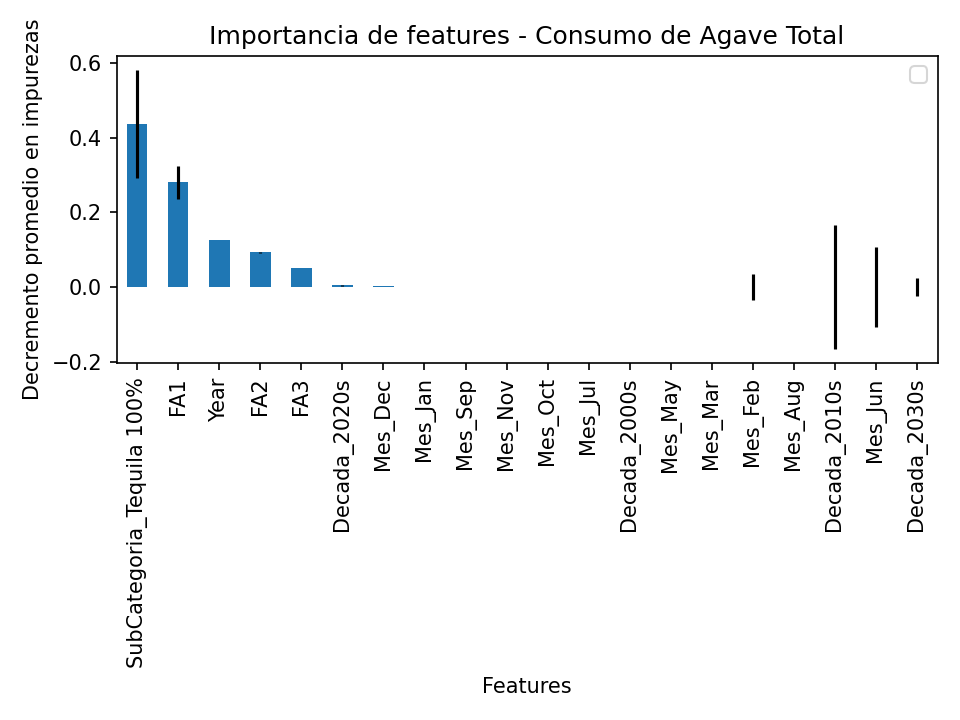

### Exportaciones total por categoria
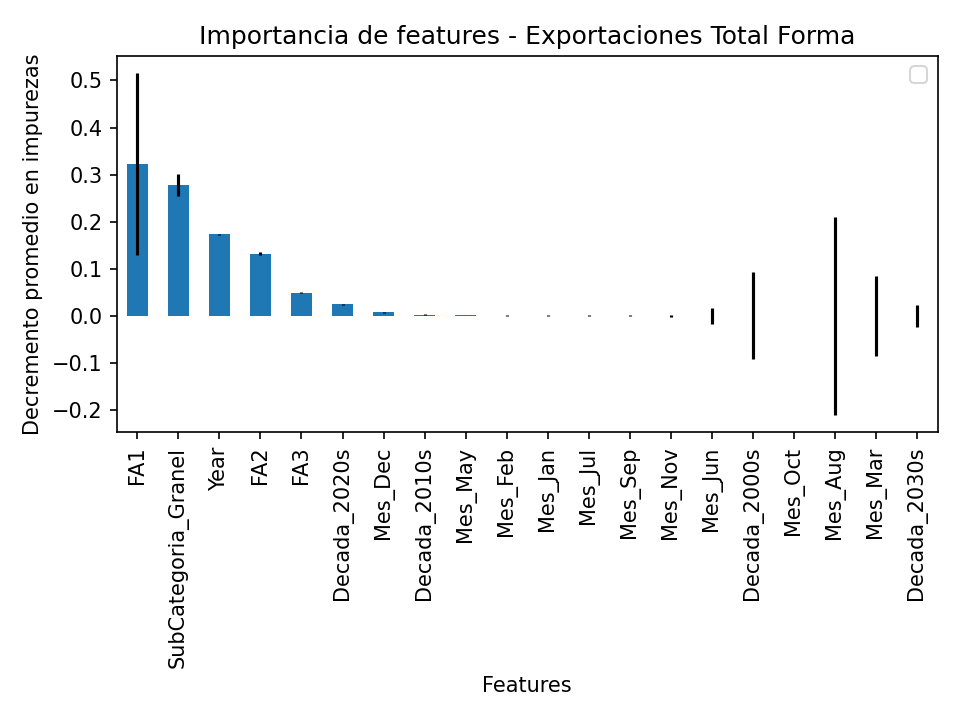


### Exportaciones total por forma
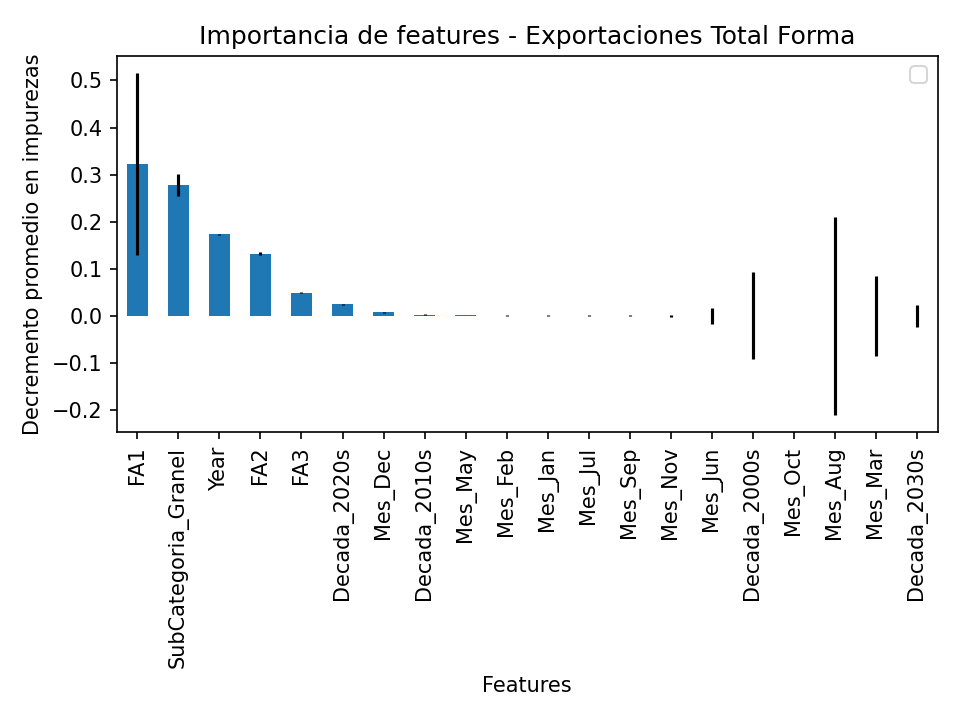


### Producción total tequila
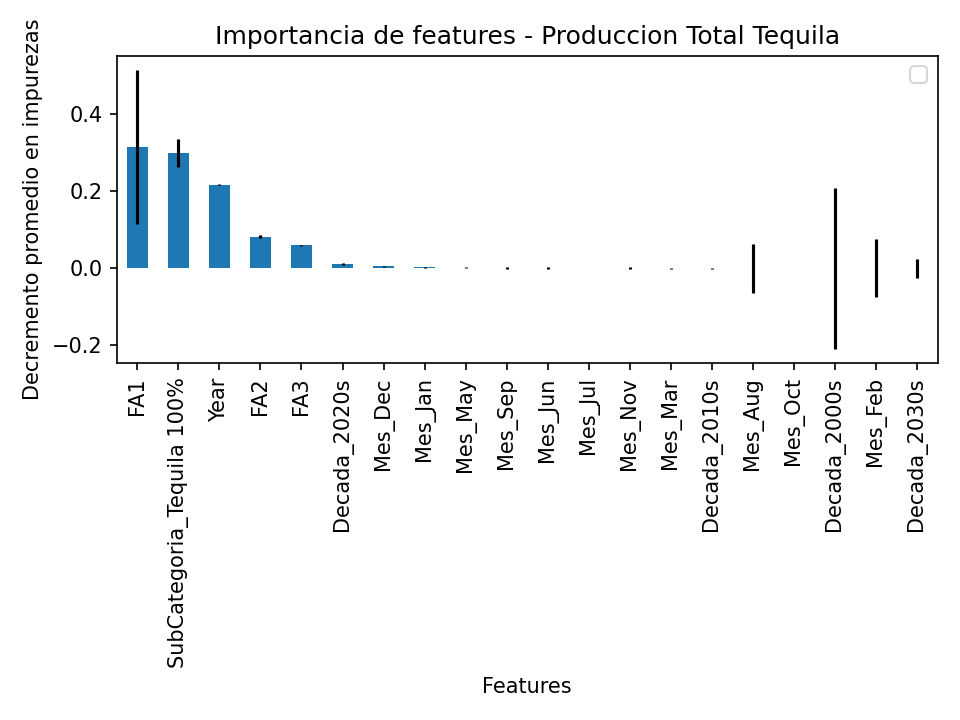

### Exportación de tequila a distintos paises

#### Exportacion tequila a USA
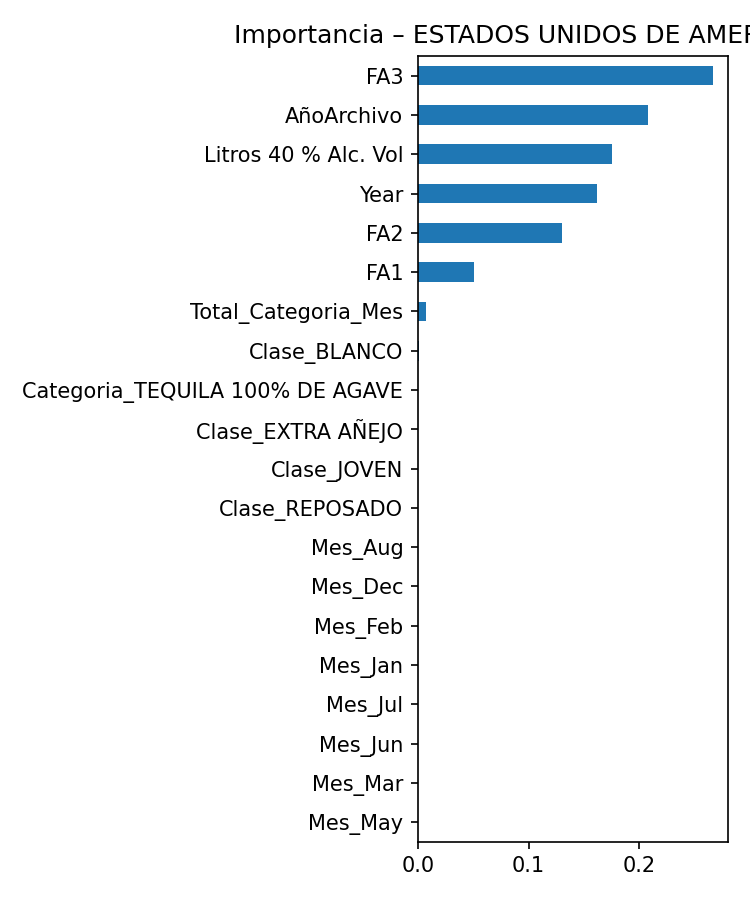


#### Exportacion tequila a Japón
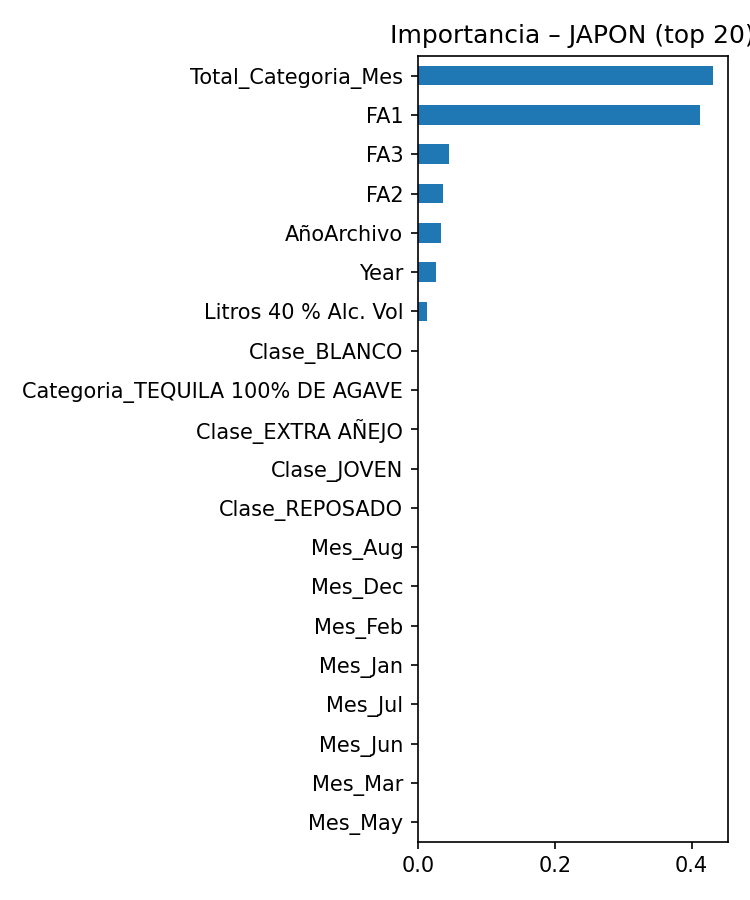





In [ ]:
def plot_feature_importance(rf_regressor_pipe, cols, name, save_path: Path | None = None,):
    forest = rf_regressor_pipe[1]
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=cols).sort_values(ascending=False)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_ylabel("Decremento promedio en impurezas")
    fig.tight_layout()
    plt.title(f"Importancia de features - {name}")
    plt.xlabel("Features")
    plt.ylabel("Decremento promedio en impurezas")
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.close()

In [ ]:
def cargar_csv_features(nombre_archivo: str) -> pd.DataFrame:
    """Carga un CSV desde BASE_PATH."""
    ruta = BASE_PATH / nombre_archivo
    df = pd.read_csv(ruta)
    return df
  #--------------
def asegurar_columna_year(df: pd.DataFrame) -> pd.DataFrame:
    """
    Asegura que el DataFrame tenga una columna 'Year'. Si ya existe, no hace nada.
    Si no existe, intenta crearla a partir de otras columnas.
    """
    if "Year" in df.columns:
        return df

    posibles = ["AñoArchivo", "Año", "Anio", "AnioArchivo", "Periodo"]
    for col in posibles:
        if col in df.columns:
            df["Year"] = df[col]
            return df

    raise ValueError(f"No se encontró alguna que se convierta en 'Year'. Columnas disponibles: {df.columns.tolist()}")

    #--------------------------
def split_Xy(
    df: pd.DataFrame,
    target: str,
    drop_cols: list[str] = None
) -> tuple[pd.DataFrame, pd.Series]:
    """
    Separa un DataFrame en X (features) e y (target), excluyendo columnas no numéricas.

    Parámetros:
    - df: DataFrame original
    - target: nombre de la columna objetivo
    - drop_cols: lista opcional de columnas a eliminar de X

    Retorna:
    - X: DataFrame con sólo variables numéricas
    - y: Serie con el objetivo
    """
    df = df.copy()
    y = df[target]
    drop_cols = drop_cols or []
    base_excluir = [target] + drop_cols
    X = df.drop(columns=base_excluir, errors="ignore")
    X = X.select_dtypes(include=["number"])  # Solo numéricas
    return X, y
#-----------------------------
def run_consolidado(nombre_archivo: str, target: str, nombre_modelo: str):
    """Entrena un modelo RandomForest para un archivo consolidado."""
    print(f"\n↳ Procesando: {nombre_modelo}")

    df = cargar_csv_features(nombre_archivo)
    df = asegurar_columna_year(df)
    df = df[df["Year"] <= 2022]

    # Validación: eliminar filas sin target
    df = df.dropna(subset=[target])
    if df.empty:
        print(f"[skip] No hay datos válidos en {nombre_archivo}")
        return

    # División X/y
    X, y = split_Xy(df, target)
    X = X.assign(Year=df["Year"].values)

    # Modelo base
    dummy_mae = -cross_val_score(
        DummyRegressor(strategy="mean"), X, y,
        cv=TimeSeriesSplit(n_splits=N_SPLITS),
        scoring="neg_mean_absolute_error"
    ).mean()

    # RandomForest + GridSearchCV
    best_pipe, mae_cv = gridsearch_rf(X, y)
    best_pipe.fit(X, y)

    plot_feature_importance(best_pipe, X.columns, nombre_modelo, RESULT_PATH / f"fi_{nombre_modelo}.png")

    # Guardado
    save_pipeline(best_pipe, nombre_modelo, mae_cv, dataset=nombre_archivo)

    # Proyección 2040
    pred_2040 = proyectar_anyo(best_pipe, X.columns.tolist(), future_year=2040)
    print(f"{nombre_modelo:30s} | MAE: {mae_cv:,.2f} | Pred 2040: {pred_2040:,.2f} (Dummy MAE: {dummy_mae:,.2f})")

    # Curva de aprendizaje
    plot_learning_curve(best_pipe, X, y, nombre_modelo, RESULT_PATH / f"lc_{nombre_modelo}.png")

    # Backcast
    back_df = backcast_years(best_pipe, X.columns.tolist(), df, target, BACKCAST_YEARS)
    back_df.to_csv(RESULT_PATH / f"backcast_{nombre_modelo.lower().replace(' ', '_')}.csv", index=False)




# 9. Resultados y Conclusiones

In [ ]:
# ───────────────────────────── main / CLI simple ─────────────────────────
if __name__ == "__main__":
    ejecutar_modelos()
    print("\nProceso completado. Modelos y metricas guardados en:", RESULT_PATH)


===== PROYECCIONES FUTURAS =====
Top-10 países: ESTADOS UNIDOS DE AMERICA, ALEMANIA, ESPAÑA, FRANCIA, REINO UNIDO DE LA GRAN BRETAÑA E IRLANDA DEL NORTE, MEXICO, CANADA, JAPON, AUSTRALIA, ITALIA

 ESTADOS UNIDOS DE AMERICA | MAE CV: 2,829,653.4 | Pred 2040: 8,543,077 L  (Dummy MAE: 3,904,462.7)
Modelo mayor o igual al desempeno minimo
Train MAE=830,335.3 | Val MAE=4,904,334.6
Back-cast:
 Year       Pred       Real AbsPct
 2020 14,182,333 16,067,747  11.7%
 2015 11,543,717 10,847,756   6.4%
 2010  8,558,283  7,938,995   7.8%

Distribución 2040 – ESTADOS UNIDOS DE AMERICA
TEQUILA 100% DE AGAVE | BLANCO          :  9.57%  (~817,912 L)
TEQUILA 100% DE AGAVE | EXTRA AÑEJO     : 61.58%  (~5,260,825 L)
TEQUILA 100% DE AGAVE | JOVEN           : 16.15%  (~1,380,076 L)
TEQUILA 100% DE AGAVE | REPOSADO        : 12.69%  (~1,084,264 L)

 ALEMANIA                  | MAE CV: 124,119.9 | Pred 2040: 185,862 L  (Dummy MAE: 184,434.4)
Modelo mayor o igual al desempeno minimo
Train MAE=55,369.3 | Val MAE

<ipython-input-10-564e75890808>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Exportaciones Total Forma      | MAE: 3.34 | Pred 2040: 9.59 (Dummy MAE: 3.69)
Train MAE=0.3 | Val MAE=4.2

↳ Procesando: Exportaciones Total Categoria


<ipython-input-10-564e75890808>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Exportaciones Total Categoria  | MAE: 3.10 | Pred 2040: 9.36 (Dummy MAE: 4.12)
Train MAE=0.3 | Val MAE=4.0

↳ Procesando: Produccion Total Tequila


<ipython-input-10-564e75890808>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Produccion Total Tequila       | MAE: 4.32 | Pred 2040: 13.25 (Dummy MAE: 5.07)
Train MAE=0.6 | Val MAE=5.3

↳ Procesando: Consumo de Agave Total


<ipython-input-10-564e75890808>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Consumo de Agave Total         | MAE: 16.70 | Pred 2040: 26.33 (Dummy MAE: 20.81)
Train MAE=2.1 | Val MAE=19.7

Proceso completado. Modelos y metricas guardados en: /content/drive/MyDrive/ProyectoIntegrador/ModeloPronosticos/resultados


# Conclusiones

9.1 Para el top 10 de los países con mayor volumen de exportaciones:
 * ESTADOS UNIDOS DE AMERICA, ALEMANIA, ESPAÑA, FRANCIA,
 * REINO UNIDO DE LA GRAN BRETAÑA E IRLANDA DEL NORTE,
 * MEXICO, CANADA, JAPON, AUSTRALIA, ITALIA,

obtuvieron una MAE por debajo del modelo dummy, esto puede interpretarse como una primer validación de la capacidad predictiva de los modelos entrenados.

9.2 La *evalución* de tipo (backcast) está por debajo del 10% del error absoluto porcentual para todos los países elegidos, lo que refuerza la confiabilidad del modelo.

9.3 Respecto a las proyecciónes estimadas con el modelo, se obtuvo que hacia el 2040, Estados Unidos de América, tendrá una proyección del 8.4 millones de litros, con una participación del 89.3% del total proyectado. Lo que confirma que es el mercado dominante en las exportaciones del tequila a nivel mundial.

9.4 En el caso de México, la proyección pronosticada para 2040 es de 83.789 litros con una participación del 0.87% respecto al total proyectado. Las clases con mayor participación son las de tequila joven (34.9%) y tequila blanco con (29.7%).

9.5 La data correspondiente a los países:
   

1.   Canadá (26.4% para el 2020),
2.   Australia (41.7% para el año 2010) e
3.    Italia (37% parael 2020),

mostraron un backcasting superior al 25% para algunos años, esto muestra mayor fluctuación en la data.

9.5 Respecto a los modelos globales consolidados se obtuvo:


| Dataset                         | MAE    | Dummy MAE | Pred 2040 |
|---------------------------------|--------|------------|-----------|
| Exportaciones Total Forma       | 3.34   | 3.69       | 9.59      |
| Exportaciones Total Categoría   | 3.10   | 4.12       | 9.36      |
| Producción Total Tequila        | 4.32   | 5.07       | 13.25     |
| Consumo de Agave Total          | 16.70  | 20.81      | 26.33     |


Lo que muestra que el dataset sobre el consumo del agave, muestra la mayor dificultad para ajustarse con el modelo (16.7). Puede indicar la presencia de variables exógenas no cosideradas dentro del modelo.
